## Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.model_selection import train_test_split, KFold
import pickle
from skimage.feature import graycomatrix, graycoprops
from skimage import img_as_ubyte
from sklearn.preprocessing import StandardScaler


import sys
import os

# Get the current working directory (which should be the directory containing the Jupyter notebook)
current_dir = os.getcwd()

# Construct the absolute path to the DataPreprocessing directory
data_preprocessing_path = os.path.join(current_dir, '..', 'DataPreprocessing')

# Add this path to sys.path
sys.path.append(os.path.abspath(data_preprocessing_path))

# Import custom preprocessing functions
from Preprocessing import filter_data, STFT_transform, split_window, create_stft_matrix, create_feature_matrix
from DataRetrieve import vui, buon, calm

(307200,)


## Compute GLCM


In [2]:
stft_images = []

stft_images = np.concatenate((create_stft_matrix(vui), create_stft_matrix(buon), create_stft_matrix(calm)))

In [3]:
stft_images[1].shape

(3841, 16)

## Train_test split

In [4]:

targets = pd.concat([pd.Series([1] * 586), pd.Series([-1] * 586), pd.Series([0]*586)]).values


X = create_feature_matrix(stft_images)
y = targets

test = X[0]
   
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X[1])
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=10, shuffle = True)

[ 0.81714589  1.84798915  2.0241414   1.77229446  2.48290378  3.00450659
  3.0781914   2.98036686 -2.57350007 -2.54352764 -2.59567509 -2.52862441
 -2.15024265 -2.25072858 -2.25986087 -2.25186937 -1.71289374 -0.09338234
 -0.06651134 -0.03395399]


In [5]:
print(test)
print(X[1].shape)
print(y.shape)
print(X_train.shape)

[ 1.45974139 14.65112847 13.32535807 14.63326389  0.55705979  1.55949653
  1.4515625   1.5553125   0.78086914  0.60579114  0.62189224  0.60655996
  0.33206076  0.28847757  0.294428    0.28891663  0.98385182  0.81290717
  0.82385728  0.81310475]
(20,)
(1758,)
(1406, 20)


## Train Model

In [6]:
results = []
models = []
label_mapping = {"Stressed": -1, 'Calm': 0, 'Goodmood': 1}

def TrainingModel(model):
    # if type(model).__name__ == "DecisionTreeClassifier":
    #     model.fit(X_train, Y_train)

    #     # Compute the cost-complexity pruning path
    #     path = model.cost_complexity_pruning_path(X_train, Y_train)
    #     ccp_alphas, impurities = path.ccp_alphas, path.impurities

    #     # Find the optimal value for ccp_alpha
    #     optimal_ccp_alpha = ccp_alphas[np.argmin(impurities)]

    #     # Set the ccp_alpha parameter
    #     model.ccp_alpha = optimal_ccp_alpha

    model.fit(X_train, Y_train)
    train_score = model.score(X_train, Y_train)
    test_score = model.score(X_test, Y_test)
    k = 10
    kf = KFold(n_splits=k)
    accuracy_list = []
    for train_index, test_index in kf.split(X_train):
        # print(train_index, test_index)
        # Split data into training and testing sets
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_list.append(accuracy)
    score = model.score(X_test, Y_test)
    accuracy_list.append(score)
    avg_accuracy = np.mean(accuracy_list)
    results.append((type(model).__name__, train_score, score, avg_accuracy))
    print("train_score: ", train_score)
    print("test_score: ", score)
    print("avg_accuracy: ", avg_accuracy)
    print(model.predict(X_test))    
    
    y_pred = np.array(model.predict(X_test))

    cm = confusion_matrix(Y_test, y_pred)
    clr = classification_report(Y_test, y_pred, target_names=label_mapping.keys())

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
    plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
    plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig(f"../Figure/TThanh_{type(model).__name__}")
    plt.show()

    print(f"Classification Report for {type(model).__name__}:\n----------------------\n", clr)

In [7]:
params = {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
model = KNeighborsClassifier()
models.append(model)

params = {'C': 50, 'gamma': 1, 'kernel': 'rbf'}
model = SVC(**params)
models.append(model)

params = {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5}
model = DecisionTreeClassifier(**params)
models.append(model)

params = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
model = RandomForestClassifier()
models.append(model)

train_score:  0.9523470839260313
test_score:  0.9289772727272727
avg_accuracy:  0.9043474779572459
[ 1  0 -1  1  0  1 -1  0 -1 -1  0 -1  1 -1 -1  0  0  1  0  0  0 -1  1  0
  1  1  1  1  0  1  1  0 -1 -1  0  0  0  0  0 -1 -1  0 -1  0  0  1 -1  1
  1 -1  0 -1 -1  0 -1  0  1  1  1 -1 -1  1  1 -1  0  1 -1  1 -1  1  1  0
  0 -1  1  1 -1  0  1 -1  0  0 -1  0  1  1  1  1 -1  0  1  0  1 -1  1 -1
  1  1  1 -1  1  1  0  0  0  0  0  1  0  0 -1  1  1 -1  1  0  1  0  1  0
  0  1  0  0  1  0 -1 -1  1  1  0  1  0 -1 -1  0 -1  1  1  1 -1  1  1 -1
  0  0 -1 -1  0 -1  0 -1 -1  0 -1  1 -1 -1  0  1 -1  0  0  1  1 -1 -1 -1
 -1 -1  0 -1  0 -1 -1  1  1  0 -1  1  1 -1 -1 -1  1  1  0  1  1 -1  0  1
  1  1  0  1  0  1 -1 -1 -1  1  0  1 -1 -1  0  0  0 -1 -1  1  0  0 -1  1
  1  0  1 -1  0  1  1  1 -1  0  0 -1  0  1 -1  0  0  0 -1  1  0  0  1  1
  0  0 -1 -1  0  0  1 -1  0  0  0  1  1  1 -1  1  0 -1  0  1 -1  1  0  0
 -1  0 -1 -1  1 -1 -1  0  0 -1  0  0  0 -1 -1  1 -1 -1 -1  1  1  0 -1  0
 -1 -1 -1  0  1  1  0 -1 

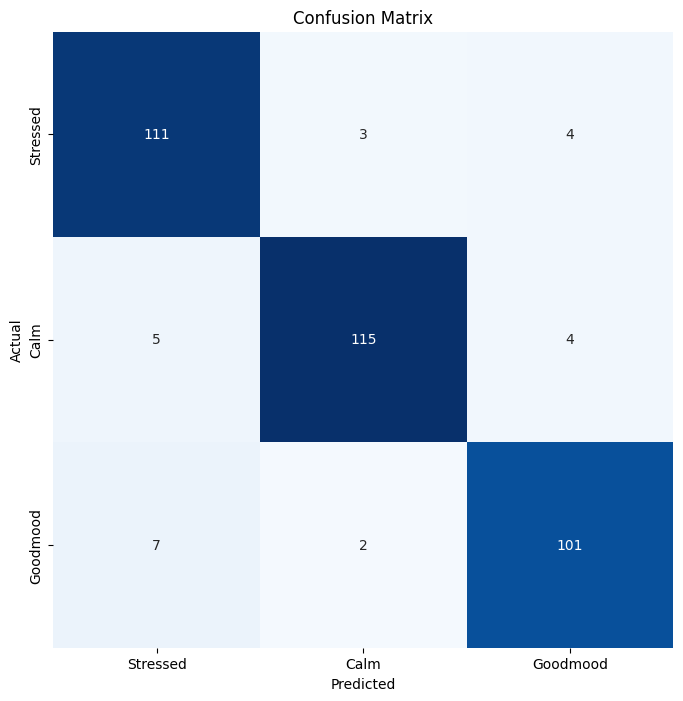

Classification Report for KNeighborsClassifier:
----------------------
               precision    recall  f1-score   support

    Stressed       0.90      0.94      0.92       118
        Calm       0.96      0.93      0.94       124
    Goodmood       0.93      0.92      0.92       110

    accuracy                           0.93       352
   macro avg       0.93      0.93      0.93       352
weighted avg       0.93      0.93      0.93       352

train_score:  1.0
test_score:  0.9573863636363636
avg_accuracy:  0.9424648006732145
[ 1  0 -1  0  0  1 -1  0 -1 -1  0 -1  1  1 -1  0  0  1  0  0  0 -1  1  0
  1  1  1  1  0  1  1  0 -1 -1  0  0  0  0  0 -1 -1  0 -1  0  0  1 -1  1
  1 -1  0 -1 -1  0 -1  0  1  1  1 -1 -1  1  1 -1  0  1 -1  1 -1  1  1  0
  0 -1  1  1  0  0  1 -1  0  0 -1  0  1  1  1  1 -1  0  1  0  0 -1  1 -1
  1  1  1 -1  1  1  0  0  0  0  0  1  0  0 -1  1  1 -1  1  0 -1  0  0  0
  0  1  0  0  1  0 -1 -1  1  1  0  1  0 -1 -1  0 -1  1  1  1 -1  1  1 -1
  0  0 -1 -1  0 -1  0  1 

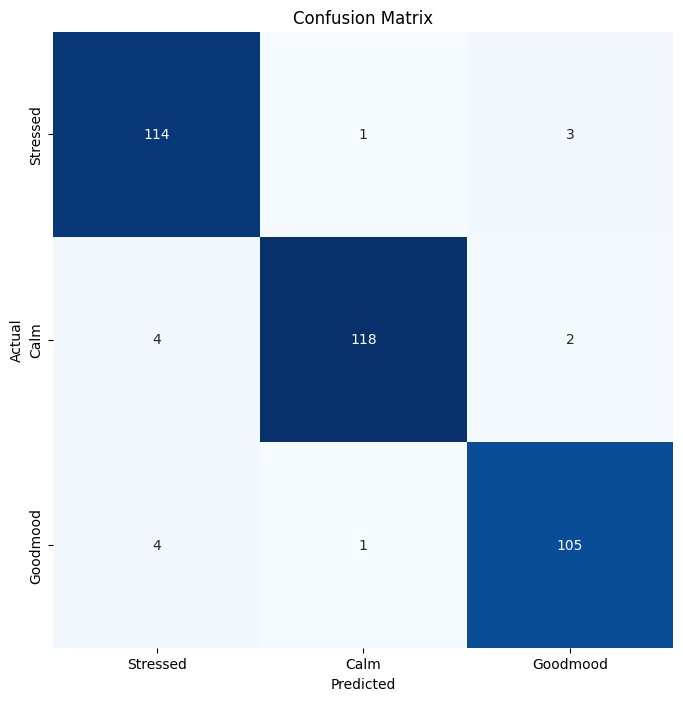

Classification Report for SVC:
----------------------
               precision    recall  f1-score   support

    Stressed       0.93      0.97      0.95       118
        Calm       0.98      0.95      0.97       124
    Goodmood       0.95      0.95      0.95       110

    accuracy                           0.96       352
   macro avg       0.96      0.96      0.96       352
weighted avg       0.96      0.96      0.96       352

train_score:  0.9182076813655761
test_score:  0.8693181818181818
avg_accuracy:  0.8678794368107714
[ 1  0  1  1  0  1 -1  0 -1 -1  0 -1  1 -1 -1  0  0  1  0  0 -1 -1  1  0
  1  1  1  1  0  1  1  0 -1 -1  0  0  0  0  0  1 -1  0 -1  0  0  0 -1  1
  1 -1  0 -1 -1  0 -1  0  1  1  1  1  1 -1  1 -1  0  1 -1  1 -1  1  0  0
  0 -1  1  1  0  0  1 -1  0  0 -1  0  1  1  1  1  1  0  1  0  1 -1  1 -1
  0  1  1 -1  1 -1  0  0  0  0  1  1  0  0 -1  1  1 -1  1  0  1  0  0  0
  0  1  0  0  1  0  0 -1  1  1  0  1  0 -1 -1  0 -1  1  1  1 -1 -1  1 -1
  0  0 -1 -1  0  1  0 -1 -1

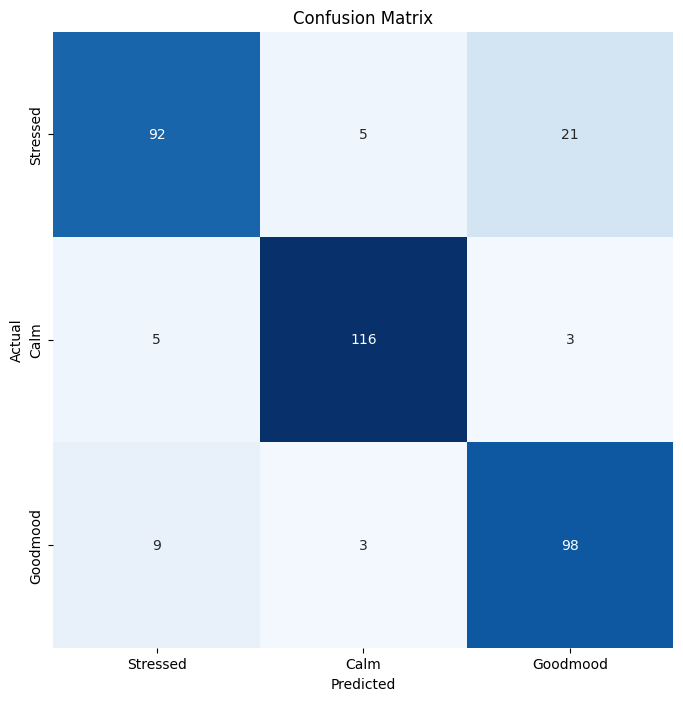

Classification Report for DecisionTreeClassifier:
----------------------
               precision    recall  f1-score   support

    Stressed       0.87      0.78      0.82       118
        Calm       0.94      0.94      0.94       124
    Goodmood       0.80      0.89      0.84       110

    accuracy                           0.87       352
   macro avg       0.87      0.87      0.87       352
weighted avg       0.87      0.87      0.87       352

train_score:  1.0
test_score:  0.9204545454545454
avg_accuracy:  0.9332678121362842
[ 1  0 -1  1  0  1 -1  0 -1 -1  0 -1  1 -1 -1  0  0  1  0  0  1 -1  1  0
  1  1  1  1  0  1  1  0 -1 -1  0  0  0  0  0 -1 -1  0  1  0  0  1 -1  1
  1 -1  0 -1 -1  0 -1  0  1  1  1 -1 -1  1  1 -1  0  1 -1  1 -1  1  1  0
  0 -1  1  1  0  0  1 -1  0  0 -1  0  1  1  1  1 -1  0  1  0  1 -1  1 -1
  1  1  1 -1  1  1  0  0  0  0 -1  1  0  1 -1  1  1 -1  1  0 -1  0  0  0
  0  1  0  0  1  0  0 -1  1  1  0  1  0 -1 -1  0 -1  1  1  1 -1  1  1 -1
  0  0 -1 -1  0 -1  0 -

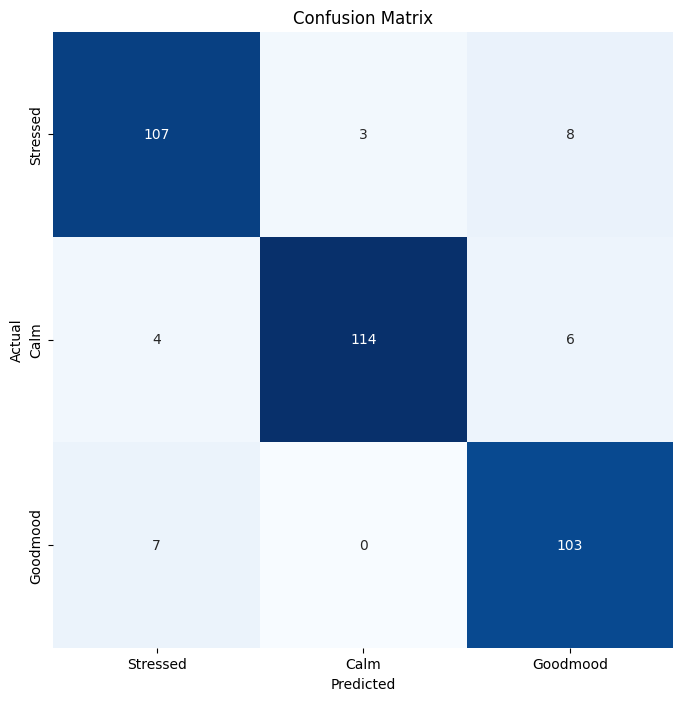

Classification Report for RandomForestClassifier:
----------------------
               precision    recall  f1-score   support

    Stressed       0.91      0.91      0.91       118
        Calm       0.97      0.92      0.95       124
    Goodmood       0.88      0.94      0.91       110

    accuracy                           0.92       352
   macro avg       0.92      0.92      0.92       352
weighted avg       0.92      0.92      0.92       352

                    Model  Train Accuracy  Test Accuracy  K fold Accuracy
0    KNeighborsClassifier        0.952347       0.928977         0.904347
1                     SVC        1.000000       0.957386         0.942465
2  DecisionTreeClassifier        0.918208       0.869318         0.867879
3  RandomForestClassifier        1.000000       0.920455         0.933268


In [8]:
for model in models:
    TrainingModel(model)
    filename = f'../trained_model/{type(model).__name__}_GLCM.h5'
    pickle.dump(model, open(filename, 'wb'))
res = pd.DataFrame(results, columns=['Model', 'Train Accuracy', 'Test Accuracy', 'K fold Accuracy'])
print(res)

with open('../trained_model/TimeFreqscaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)